# 죽산보 데이터 분석: 승촌보 데이터 모든 특성 윈도우 추가

## 주요 내용

- 죽산보와 승촌보 데이터의 기초 통계 비교

## 데이터 정보

* 죽산보/승촌보 수질 데이터
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 죽산보/승촌보 유량 데이터
    * 2012-2022년
    * 10분 단위 수집 데이터

## 필수 모듈 임포트

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from datetime import datetime

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error

**데이터프레임 설정**

In [3]:
pd.set_option('display.max_columns', None) # 모든 특성이 잘리지 않도록 함.

**matplotlib 한글 설정**

In [4]:
# !pip install koreanize_matplotlib
# import koreanize_matplotlib

## 죽산보 데이터 불러오기

**디렉토리 관리 객체**

In [5]:
from pathlib import Path

**데이터 저장소**

In [6]:
from pathlib import Path

base_path = Path("../data")

**보 이름**

- 영산강에 설치된 승촌보와 죽산보 중에 죽산보 데이터만 활용

In [7]:
weirs = ['죽산보', '승촌보']

### 수질/기상 데이터 불러오기

**데이터 연도**

- 2012년부터 2023년도 사이의 데이터
- **시간 단위**의 데이터
- 죽산보 수량 데이터는 10분 단위의 데이터이며 다른 형식의 엑셀 파일에 저장되어 있어서 다른 방식으로 불러와야 함.

In [8]:
years = range(2012, 2024)

**디렉토리에서 원하는 파일목록 리스트로 가져오기**

- 16개 보의 기상 데이터와 수질 데이터가 연도별로 수집되어 있음.

In [9]:
import os

def file_arr(path):
    arr = []
    fileList = os.listdir(path)
    fileList.sort()
    
    for f in fileList:
        # 임시 파일 제외
        if f.find('~$') != -1:
            continue
        if f.find('zNex~$hare') != -1:
            continue
        if f.find('.xlsx') != -1:
            arr.append(path / f)
    return arr

- 16개 보의 수질 데이터를 담고 있는 연도별 파일 목록

In [10]:
file_arr(base_path / '16개 보_수질 데이터')

[PosixPath('../data/16개 보_수질 데이터/수질_2012년도(7~12월).xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2013년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2014년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2015년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2016년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2017년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2018년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2019년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2020년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2021년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2022년도.xlsx'),
 PosixPath('../data/16개 보_수질 데이터/수질_2023년도(1~8월).xlsx')]

- 16개 보의 기상 데이터를 담고 있는 연도별 파일 목록

In [11]:
file_arr(base_path / '16개 보_기상 데이터')

[PosixPath('../data/16개 보_기상 데이터/기상_2012년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2013년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2014년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2015년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2016년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2017년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2018년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2019년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2020년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2021년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2022년도.xlsx'),
 PosixPath('../data/16개 보_기상 데이터/기상_2023년도.xlsx')]

**연도별 수질 데이터 불러오기**

- 16개 보 수질/기상 데이터를 객체를 값으로 갖는 사전으로 불러오는 함수

In [12]:
from collections import defaultdict

def data_merge(dirName):
    ndriver_weir_dict = defaultdict(dict)
    fileList = file_arr(base_path / dirName)
    
    for f in fileList:
        if '20' in f.name and '년' in f.name:
            year = f.name[f.name.find('20'): f.name.find('20') + 4]
        else:
            year = f'20{f.name[-7:-5]}'

        print(f'===== {year} 시작 =====')
            
        # pd.ExcelFile() 함수를 이용하여 엑셀 파일 정보와 함께 시트별로 데이터 불러옴
        with pd.ExcelFile(f) as xls:
            for sheetName in xls.sheet_names:
                if '(' in sheetName:
                    idx = sheetName.index('(')
                    weir = sheetName[:idx]
                elif '·' in sheetName:
                    weir = sheetName.replace('·', '')
                else:
                    weir = sheetName

                if weir in weirs:
                    ndriver_weir_dict[weir][year] = pd.read_excel(xls, sheet_name = sheetName)
                    print(f'{weir}', end = ', ')
            print()

    return ndriver_weir_dict

- 죽산보/승촌보 수질 데이터 불러오기

In [13]:
jsb_wq = data_merge('16개 보_수질 데이터')

===== 2012 시작 =====
승촌보, 죽산보, 
===== 2013 시작 =====
승촌보, 죽산보, 
===== 2014 시작 =====
승촌보, 죽산보, 
===== 2015 시작 =====
승촌보, 죽산보, 
===== 2016 시작 =====
승촌보, 죽산보, 
===== 2017 시작 =====
승촌보, 죽산보, 
===== 2018 시작 =====
승촌보, 죽산보, 
===== 2019 시작 =====
승촌보, 죽산보, 
===== 2020 시작 =====
승촌보, 죽산보, 
===== 2021 시작 =====
승촌보, 죽산보, 
===== 2022 시작 =====
승촌보, 죽산보, 
===== 2023 시작 =====
승촌보, 죽산보, 


In [14]:
jsb_wq.keys()

dict_keys(['승촌보', '죽산보'])

In [15]:
jsb_wq['승촌보'].keys()

dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])

In [16]:
jsb_wq['죽산보'].keys()

dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])

- 예제: 죽산보 2012년 수질 데이터

In [17]:
jsb_wq['죽산보']['2012']

,측정일(시),수온 (℃),수소이온농도,전기전도도 (μS/cm),용존산소 (mg/L),탁도 (NTU),총유기탄소 (mg/L),총질소 (mg/L),총인 (mg/L),클로로필-a (mg/㎥)
0,2012-07-01 00h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-07-01 01h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-07-01 02h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-07-01 03h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-07-01 04h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4411,2012-12-31 19h,3.2,6.8,271.0,12.2,1.9,1.9,NaN,NaN,11.9
4412,2012-12-31 20h,3.0,6.8,272.0,12.2,1.7,1.9,NaN,NaN,11.6
4413,2012-12-31 21h,3.2,6.8,272.0,12.3,6.4,1.9,NaN,NaN,11.6
4414,2012-12-31 22h,3.1,6.8,272.0,12.2,2.1,1.9,NaN,NaN,11.7


- 예제: 승촌보 2012년 수질 데이터

In [18]:
jsb_wq['승촌보']['2012']

,측정일(시),수온 (℃),수소이온농도,전기전도도 (μS/cm),용존산소 (mg/L),총유기탄소 (mg/L),총질소 (mg/L),총인 (mg/L),클로로필-a (mg/㎥)
0,2012-07-01 00h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-07-01 01h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-07-01 02h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-07-01 03h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-07-01 04h,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4411,2012-12-31 19h,4.4,6.9,374.0,11.3,2.5,NaN,NaN,6.9
4412,2012-12-31 20h,4.3,6.9,374.0,11.4,2.5,NaN,NaN,7.2
4413,2012-12-31 21h,4.3,6.9,373.0,11.4,2.5,NaN,NaN,7.0
4414,2012-12-31 22h,4.3,6.9,375.0,11.4,2.5,NaN,NaN,7.1


- 죽산보/승촌보 기상 데이터 불러오기

In [19]:
jsb_weather = data_merge('16개 보_기상 데이터')

===== 2012 시작 =====
승촌보, 죽산보, 
===== 2013 시작 =====
승촌보, 죽산보, 
===== 2014 시작 =====
승촌보, 죽산보, 
===== 2015 시작 =====
승촌보, 죽산보, 
===== 2016 시작 =====
승촌보, 죽산보, 
===== 2017 시작 =====
승촌보, 죽산보, 
===== 2018 시작 =====
승촌보, 죽산보, 
===== 2019 시작 =====
승촌보, 죽산보, 
===== 2020 시작 =====
승촌보, 죽산보, 
===== 2021 시작 =====
승촌보, 죽산보, 
===== 2022 시작 =====
승촌보, 죽산보, 
===== 2023 시작 =====
승촌보, 죽산보, 


In [20]:
jsb_weather.keys()

dict_keys(['승촌보', '죽산보'])

In [21]:
jsb_weather['죽산보'].keys()

dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])

In [22]:
jsb_weather['승촌보'].keys()

dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])

- 예제: 죽산보 2012년 기상 데이터

In [23]:
jsb_weather['죽산보']['2012']

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위)
0,156,광주,2012-07-01 00:00:00,21.6,NaN,2.1,NaN,NaN,8.0,8.0
1,156,광주,2012-07-01 01:00:00,21.3,NaN,1.6,NaN,NaN,NaN,NaN
2,156,광주,2012-07-01 02:00:00,21.1,NaN,0.8,NaN,NaN,NaN,NaN
3,156,광주,2012-07-01 03:00:00,21.1,NaN,1.3,NaN,NaN,9.0,9.0
4,156,광주,2012-07-01 04:00:00,21.0,NaN,0.4,NaN,NaN,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...
4411,156,광주,2012-12-31 19:00:00,-2.3,NaN,2.5,NaN,NaN,6.0,6.0
4412,156,광주,2012-12-31 20:00:00,-2.7,NaN,1.8,NaN,NaN,7.0,7.0
4413,156,광주,2012-12-31 21:00:00,-2.9,0.2,0.6,NaN,NaN,6.0,6.0
4414,156,광주,2012-12-31 22:00:00,-3.4,NaN,0.1,NaN,NaN,NaN,NaN


- 예제: 승촌보 2012년 기상 데이터

In [24]:
jsb_weather['승촌보']['2012']

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위)
0,156,광주,2012-07-01 00:00:00,21.6,NaN,2.1,NaN,NaN,8.0,8.0
1,156,광주,2012-07-01 01:00:00,21.3,NaN,1.6,NaN,NaN,NaN,NaN
2,156,광주,2012-07-01 02:00:00,21.1,NaN,0.8,NaN,NaN,NaN,NaN
3,156,광주,2012-07-01 03:00:00,21.1,NaN,1.3,NaN,NaN,9.0,9.0
4,156,광주,2012-07-01 04:00:00,21.0,NaN,0.4,NaN,NaN,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...
4411,156,광주,2012-12-31 19:00:00,-2.3,NaN,2.5,NaN,NaN,6.0,6.0
4412,156,광주,2012-12-31 20:00:00,-2.7,NaN,1.8,NaN,NaN,7.0,7.0
4413,156,광주,2012-12-31 21:00:00,-2.9,0.2,0.6,NaN,NaN,6.0,6.0
4414,156,광주,2012-12-31 22:00:00,-3.4,NaN,0.1,NaN,NaN,NaN,NaN


**수질/기상 데이터 통합**

In [25]:
def merge_weir_df(weir):
    df_concat = pd.DataFrame()
    
    for year in years:
        df1 = jsb_wq[weir][str(year)]
        df2 = jsb_weather[weir][str(year)]
#         df3 = jsb_dflow[weir][str(year)]
        
        df1 = df1.astype({'측정일(시)': 'datetime64[ns]'})
        df2 = df2.astype({'일시': 'datetime64[ns]'}) 
#         df3 = df3.astype({'측정일(시)': 'datetime64[ns]'})
                                  
        df = pd.merge(df1, df2, left_on = '측정일(시)', right_on = '일시', how = 'left').drop(columns = '일시')
#         df = pd.merge(df, df3, how = 'left')
                                  
        df_concat = pd.concat([df_concat, df]).reset_index(drop = True)

    df_concat = df_concat.set_index('측정일(시)')
    return df_concat

In [26]:
jsb_df = merge_weir_df('죽산보')

jsb_df

,수온 (℃),수소이온농도,전기전도도 (μS/cm),용존산소 (mg/L),탁도 (NTU),총유기탄소 (mg/L),총질소 (mg/L),총인 (mg/L),클로로필-a (mg/㎥),지점,지점명,기온(°C),강수량(mm),풍속(m/s),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위)
측정일(시),,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.6,NaN,2.1,NaN,NaN,8.0,8.0
2012-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.3,NaN,1.6,NaN,NaN,NaN,NaN
2012-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.1,NaN,0.8,NaN,NaN,NaN,NaN
2012-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.1,NaN,1.3,NaN,NaN,9.0,9.0
2012-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.0,NaN,0.4,NaN,NaN,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 19:00:00,25.1,6.5,115.0,6.8,33.1,3.2,1.790,NaN,5.0,156,광주,25.2,NaN,0.7,0.4,0.24,7.0,0.0
2023-08-31 20:00:00,24.9,6.5,117.0,6.9,33.1,3.1,1.786,NaN,5.0,156,광주,24.0,NaN,0.6,0.0,0.05,7.0,0.0
2023-08-31 21:00:00,24.8,6.4,119.0,6.8,31.8,3.2,1.753,NaN,5.1,156,광주,22.9,NaN,1.9,NaN,NaN,0.0,0.0


In [27]:
scb_df = merge_weir_df('승촌보')

scb_df

,수온 (℃),수소이온농도,전기전도도 (μS/cm),용존산소 (mg/L),총유기탄소 (mg/L),총질소 (mg/L),총인 (mg/L),클로로필-a (mg/㎥),지점,지점명,기온(°C),강수량(mm),풍속(m/s),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위)
측정일(시),,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.6,NaN,2.1,NaN,NaN,8.0,8.0
2012-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.3,NaN,1.6,NaN,NaN,NaN,NaN
2012-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.1,NaN,0.8,NaN,NaN,NaN,NaN
2012-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.1,NaN,1.3,NaN,NaN,9.0,9.0
2012-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156,광주,21.0,NaN,0.4,NaN,NaN,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31 19:00:00,25.9,7.0,161.0,6.2,NaN,1.549,0.169,11.2,156,광주,25.2,NaN,0.7,0.4,0.24,7.0,0.0
2023-08-31 20:00:00,26.0,7.1,162.0,6.2,NaN,1.561,0.17,11.5,156,광주,24.0,NaN,0.6,0.0,0.05,7.0,0.0
2023-08-31 21:00:00,26.1,7.0,166.0,6,NaN,1.544,0.171,11.5,156,광주,22.9,NaN,1.9,NaN,NaN,0.0,0.0


**탁도 특성이 승촌보 데이터에 없음**

In [ ]:
jsb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         83510 non-null  float64
 1   수소이온농도         83602 non-null  float64
 2   전기전도도 (μS/cm)  83518 non-null  float64
 3   용존산소 (mg/L)    82326 non-null  object 
 4   탁도 (NTU)       82651 non-null  float64
 5   총유기탄소 (mg/L)   77093 non-null  float64
 6   총질소 (mg/L)     75725 non-null  float64
 7   총인 (mg/L)      76715 non-null  float64
 8   클로로필-a (mg/㎥)  81256 non-null  float64
 9   지점             97896 non-null  int64  
 10  지점명            97896 non-null  object 
 11  기온(°C)         97884 non-null  float64
 12  강수량(mm)        10444 non-null  float64
 13  풍속(m/s)        97862 non-null  float64
 14  일조(hr)         53272 non-null  float64
 15  일사(MJ/m2)      53521 non-null  float64
 16  전운량(10분위)      86142 non-null  float64
 17  중하층운량(10분위)    

In [29]:
scb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         75932 non-null  float64
 1   수소이온농도         75912 non-null  float64
 2   전기전도도 (μS/cm)  75843 non-null  float64
 3   용존산소 (mg/L)    74677 non-null  object 
 4   총유기탄소 (mg/L)   69665 non-null  float64
 5   총질소 (mg/L)     68592 non-null  float64
 6   총인 (mg/L)      67585 non-null  object 
 7   클로로필-a (mg/㎥)  74470 non-null  float64
 8   지점             97896 non-null  int64  
 9   지점명            97896 non-null  object 
 10  기온(°C)         97884 non-null  float64
 11  강수량(mm)        10444 non-null  float64
 12  풍속(m/s)        97862 non-null  float64
 13  일조(hr)         53272 non-null  float64
 14  일사(MJ/m2)      53521 non-null  float64
 15  전운량(10분위)      86142 non-null  float64
 16  중하층운량(10분위)    90178 non-null  float64
dtypes: float64(13),

**참고**

- 2012년 7월 1일부터 2023년 8월 31일까지의 시간 데이터 수

In [30]:
len(pd.date_range('2012-07-01 00:00:00', '2023-08-31 23:00:00', freq = 'h'))

97896

### 수량 데이터 불러오기

- 죽산보/승촌보 수량 데이터는 `'yeongsanriver_weir_dflow'` 디렉토리에 있음.
- 연도별 데이터는 시트(sheet)로 구분됨.
- 수질/기상 데이터와는 달리 **10분 단위**의 데이터로 구성됨.

In [31]:
dflow_file = base_path / "yeongsanriver_weir_dflow"

In [32]:
files = ["Jugsanbo_dflow.xlsx", "Seungchonbo_dflow.xlsx"]

In [33]:
jsb_dflow_yearly = pd.read_excel(dflow_file / files[0], 
#                                  skiprows=0, 
                                 header=0, 
                                 sheet_name=None,
                                 na_values='ND',
#                                  parse_dates=[0]  # 시간 특성을 date time으로 파싱
                                )

In [34]:
scb_dflow_yearly = pd.read_excel(dflow_file / files[1], 
#                                  skiprows=0, 
                                 header=0, 
                                 sheet_name=None,
                                 na_values='ND',
#                                  parse_dates=[0]  # 시간 특성을 date time으로 파싱
                                )

In [35]:
jsb_dflow_yearly.keys()

dict_keys(['2012(7~12월)', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023(1~8월)'])

In [36]:
scb_dflow_yearly.keys()

dict_keys(['2012(7~12월)', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023(1~8월)'])

- 2012 수량 데이터

In [37]:
jsb_dflow_yearly['2012(7~12월)']

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2012.07.01 00:00,3.69,0.00,0.0,0.0
1,2012.07.01 00:10,3.70,0.00,0.0,0.0
2,2012.07.01 00:20,3.71,0.00,0.0,0.0
3,2012.07.01 00:30,3.70,0.00,0.0,0.0
4,2012.07.01 00:40,3.70,0.00,0.0,0.0
...,...,...,...,...,...
26491,2012.12.31 23:10,3.74,-1.68,42.0,42.0
26492,2012.12.31 23:20,3.74,-1.68,42.0,42.0
26493,2012.12.31 23:30,3.74,-1.68,42.0,42.0
26494,2012.12.31 23:40,3.74,-1.68,42.0,42.0


In [38]:
scb_dflow_yearly['2012(7~12월)']

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2012.07.01 00:00,7.67,0.00,0.00,0.00
1,2012.07.01 00:10,7.67,0.00,0.00,0.00
2,2012.07.01 00:20,7.67,0.00,0.00,0.00
3,2012.07.01 00:30,7.67,0.00,0.00,0.00
4,2012.07.01 00:40,7.67,0.00,0.00,0.00
...,...,...,...,...,...
26491,2012.12.31 23:10,7.50,3.77,19.73,19.71
26492,2012.12.31 23:20,7.50,3.77,19.76,19.82
26493,2012.12.31 23:30,7.50,3.77,19.79,19.83
26494,2012.12.31 23:40,7.50,3.77,19.84,19.86


- 2013 수량 데이터

In [39]:
jsb_dflow_yearly['2013']

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013.01.01 00:00,3.74,-1.70,42.00,42.00
1,2013.01.01 00:10,3.74,-1.71,42.00,42.00
2,2013.01.01 00:20,3.74,-1.71,42.00,42.00
3,2013.01.01 00:30,3.74,-1.71,42.00,42.00
4,2013.01.01 00:40,3.74,-1.71,42.00,42.00
...,...,...,...,...,...
52555,2013.12.31 23:10,3.53,-1.18,17.33,17.30
52556,2013.12.31 23:20,3.53,-1.17,17.30,17.28
52557,2013.12.31 23:30,3.53,-1.17,17.29,17.29
52558,2013.12.31 23:40,3.53,-1.18,17.28,17.27


In [40]:
scb_dflow_yearly['2013']

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013.01.01 00:00,7.50,3.77,19.82,19.74
1,2013.01.01 00:10,7.50,3.77,19.78,19.76
2,2013.01.01 00:20,7.50,3.77,19.77,19.82
3,2013.01.01 00:30,7.50,3.77,19.77,19.73
4,2013.01.01 00:40,7.50,3.77,19.78,19.79
...,...,...,...,...,...
52555,2013.12.31 23:10,7.52,3.55,10.87,10.86
52556,2013.12.31 23:20,7.52,3.55,10.87,10.87
52557,2013.12.31 23:30,7.52,3.55,10.86,10.85
52558,2013.12.31 23:40,7.52,3.55,10.86,10.85


- 2023 수량 데이터

In [41]:
jsb_dflow_yearly['2023(1~8월)']

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2023.01.01 00:00,1.52,-1.48,10.35,10.34
1,2023.01.01 00:10,1.52,-1.48,10.38,10.37
2,2023.01.01 00:20,1.52,-1.47,10.38,10.42
3,2023.01.01 00:30,1.52,-1.47,10.41,10.44
4,2023.01.01 00:40,1.52,-1.47,10.42,10.39
...,...,...,...,...,...
34950,2023.08.31 23:10,1.52,-1.66,200.77,205.06
34951,2023.08.31 23:20,1.52,-1.61,202.82,205.03
34952,2023.08.31 23:30,1.52,-1.56,218.66,204.88
34953,2023.08.31 23:40,1.51,-1.55,193.46,204.63


In [42]:
scb_dflow_yearly['2023(1~8월)']

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2023.01.01 00:00,5.96,1.59,10.79,10.78
1,2023.01.01 00:10,5.96,1.59,10.78,10.78
2,2023.01.01 00:20,5.96,1.59,10.78,10.78
3,2023.01.01 00:30,5.96,1.59,10.79,10.80
4,2023.01.01 00:40,5.96,1.59,10.79,10.80
...,...,...,...,...,...
34962,2023.08.31 23:10,6.06,1.81,77.20,63.38
34963,2023.08.31 23:20,6.06,1.81,76.51,63.46
34964,2023.08.31 23:30,6.07,1.81,79.94,63.49
34965,2023.08.31 23:40,6.08,1.80,79.17,63.55


**년도별 수량 데이터 통합**

년도별 데이터를 통합해서 하나의 데이터프레임으로 만드는 함수

In [43]:
def concat_yearly_data(yearly_df_dict):
    df_concat = pd.DataFrame()

    for year in list(yearly_df_dict.keys()):
        df_concat = pd.concat([df_concat, yearly_df_dict[year]])

    return df_concat

In [44]:
jsb_dflow_10 = concat_yearly_data(jsb_dflow_yearly)
jsb_dflow_10

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2012.07.01 00:00,3.69,0.00,0.00,0.00
1,2012.07.01 00:10,3.70,0.00,0.00,0.00
2,2012.07.01 00:20,3.71,0.00,0.00,0.00
3,2012.07.01 00:30,3.70,0.00,0.00,0.00
4,2012.07.01 00:40,3.70,0.00,0.00,0.00
...,...,...,...,...,...
34950,2023.08.31 23:10,1.52,-1.66,200.77,205.06
34951,2023.08.31 23:20,1.52,-1.61,202.82,205.03
34952,2023.08.31 23:30,1.52,-1.56,218.66,204.88
34953,2023.08.31 23:40,1.51,-1.55,193.46,204.63


In [45]:
scb_dflow_10 = concat_yearly_data(scb_dflow_yearly)
scb_dflow_10

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2012.07.01 00:00,7.67,0.00,0.00,0.00
1,2012.07.01 00:10,7.67,0.00,0.00,0.00
2,2012.07.01 00:20,7.67,0.00,0.00,0.00
3,2012.07.01 00:30,7.67,0.00,0.00,0.00
4,2012.07.01 00:40,7.67,0.00,0.00,0.00
...,...,...,...,...,...
34962,2023.08.31 23:10,6.06,1.81,77.20,63.38
34963,2023.08.31 23:20,6.06,1.81,76.51,63.46
34964,2023.08.31 23:30,6.07,1.81,79.94,63.49
34965,2023.08.31 23:40,6.08,1.80,79.17,63.55


In [46]:
jsb_dflow_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 587146 entries, 0 to 34954
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   시간           587146 non-null  object 
 1    상류수위(EL.m)  587146 non-null  float64
 2    하류수위(EL.m)  587146 non-null  float64
 3    유입량(㎥/s)    587146 non-null  float64
 4    방류량(㎥/s)    587146 non-null  float64
dtypes: float64(4), object(1)
memory usage: 26.9+ MB


In [47]:
scb_dflow_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 587072 entries, 0 to 34966
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   시간           587072 non-null  object 
 1    상류수위(EL.m)  587072 non-null  float64
 2    하류수위(EL.m)  587072 non-null  float64
 3    유입량(㎥/s)    587072 non-null  float64
 4    방류량(㎥/s)    587072 non-null  float64
dtypes: float64(4), object(1)
memory usage: 26.9+ MB


**시간 특성 전처리**

- 2019년도 이후의 데이터에 시간이 `24:00`가 `00:00`과 함께 동시에 사용된 경우가 있음.
- 따라서 이런 데이터를 삭제해야 함.

In [48]:
mask = jsb_dflow_10['시간'].map(lambda x: '24:00' in x)
mask.sum()

103

In [49]:
jsb_dflow_10 = jsb_dflow_10.loc[~mask]
jsb_dflow_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 587043 entries, 0 to 34954
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   시간           587043 non-null  object 
 1    상류수위(EL.m)  587043 non-null  float64
 2    하류수위(EL.m)  587043 non-null  float64
 3    유입량(㎥/s)    587043 non-null  float64
 4    방류량(㎥/s)    587043 non-null  float64
dtypes: float64(4), object(1)
memory usage: 26.9+ MB


In [50]:
mask = scb_dflow_10['시간'].map(lambda x: '24:00' in x)
mask.sum()

135

In [51]:
scb_dflow_10 = scb_dflow_10.loc[~mask]
scb_dflow_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 586937 entries, 0 to 34966
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   시간           586937 non-null  object 
 1    상류수위(EL.m)  586937 non-null  float64
 2    하류수위(EL.m)  586937 non-null  float64
 3    유입량(㎥/s)    586937 non-null  float64
 4    방류량(㎥/s)    586937 non-null  float64
dtypes: float64(4), object(1)
memory usage: 26.9+ MB


`'시간'` 특성을 `datatime` 자료형으로 변환한다.

In [52]:
jsb_dflow_10 = jsb_dflow_10.astype({'시간': 'datetime64[ns]'})
jsb_dflow_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 587043 entries, 0 to 34954
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   시간           587043 non-null  datetime64[ns]
 1    상류수위(EL.m)  587043 non-null  float64       
 2    하류수위(EL.m)  587043 non-null  float64       
 3    유입량(㎥/s)    587043 non-null  float64       
 4    방류량(㎥/s)    587043 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 26.9 MB


In [53]:
scb_dflow_10 = scb_dflow_10.astype({'시간': 'datetime64[ns]'})
scb_dflow_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 586937 entries, 0 to 34966
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   시간           586937 non-null  datetime64[ns]
 1    상류수위(EL.m)  586937 non-null  float64       
 2    하류수위(EL.m)  586937 non-null  float64       
 3    유입량(㎥/s)    586937 non-null  float64       
 4    방류량(㎥/s)    586937 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 26.9 MB


인덱스를 `'시간'` 특성으로 변경한 후에 정렬한다.

In [54]:
jsb_dflow_10 = jsb_dflow_10.set_index('시간')
jsb_dflow_10 = jsb_dflow_10.sort_index()
jsb_dflow_10

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
시간,,,,
2012-07-01 00:00:00,3.69,0.00,0.00,0.00
2012-07-01 00:10:00,3.70,0.00,0.00,0.00
2012-07-01 00:20:00,3.71,0.00,0.00,0.00
2012-07-01 00:30:00,3.70,0.00,0.00,0.00
2012-07-01 00:40:00,3.70,0.00,0.00,0.00
...,...,...,...,...
2023-08-31 23:10:00,1.52,-1.66,200.77,205.06
2023-08-31 23:20:00,1.52,-1.61,202.82,205.03
2023-08-31 23:30:00,1.52,-1.56,218.66,204.88


In [55]:
scb_dflow_10 = scb_dflow_10.set_index('시간')
scb_dflow_10 = scb_dflow_10.sort_index()
scb_dflow_10

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
시간,,,,
2012-07-01 00:00:00,7.67,0.00,0.00,0.00
2012-07-01 00:10:00,7.67,0.00,0.00,0.00
2012-07-01 00:20:00,7.67,0.00,0.00,0.00
2012-07-01 00:30:00,7.67,0.00,0.00,0.00
2012-07-01 00:40:00,7.67,0.00,0.00,0.00
...,...,...,...,...
2023-08-31 23:10:00,6.06,1.81,77.20,63.38
2023-08-31 23:20:00,6.06,1.81,76.51,63.46
2023-08-31 23:30:00,6.07,1.81,79.94,63.49


### 수량 데이터 통합

**10분 단위를 1시간 단위로 변경**  

먼저 시간별 평균값을 활용하여 1시간 단위 데이터로 변환한다.

In [56]:
jsb_dflow = jsb_dflow_10.resample("h").mean()
jsb_dflow

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
시간,,,,
2012-07-01 00:00:00,3.700000,0.000000,0.000000,0.000000
2012-07-01 01:00:00,3.706667,0.000000,0.000000,0.000000
2012-07-01 02:00:00,3.718333,0.000000,0.000000,0.000000
2012-07-01 03:00:00,3.723333,0.000000,0.000000,0.000000
2012-07-01 04:00:00,3.728333,0.000000,0.000000,0.000000
...,...,...,...,...
2023-08-31 19:00:00,1.520000,-0.758333,229.176667,202.258333
2023-08-31 20:00:00,1.530000,-0.990000,214.316667,206.406667
2023-08-31 21:00:00,1.530000,-1.431667,206.468333,206.518333


In [57]:
scb_dflow = scb_dflow_10.resample("h").mean()
scb_dflow

,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
시간,,,,
2012-07-01 00:00:00,7.670000,0.000000,0.000000,0.000000
2012-07-01 01:00:00,7.666667,0.000000,0.000000,0.000000
2012-07-01 02:00:00,7.660000,0.000000,0.000000,0.000000
2012-07-01 03:00:00,7.653333,0.000000,0.000000,0.000000
2012-07-01 04:00:00,7.650000,0.000000,0.000000,0.000000
...,...,...,...,...
2023-08-31 19:00:00,5.998333,1.791667,62.318333,62.178333
2023-08-31 20:00:00,6.000000,1.806667,63.395000,62.163333
2023-08-31 21:00:00,6.011667,1.818333,68.998333,62.310000


수질/기상 데이터와 날짜를 기준으로 통합한다.

In [58]:
jsb_data = jsb_df.join(jsb_dflow, how = 'left')

In [59]:
scb_data = scb_df.join(scb_dflow, how = 'left')

날짜를 기준으로 정렬한다.

In [60]:
jsb_data = jsb_data.sort_index()
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         83510 non-null  float64
 1   수소이온농도         83602 non-null  float64
 2   전기전도도 (μS/cm)  83518 non-null  float64
 3   용존산소 (mg/L)    82326 non-null  object 
 4   탁도 (NTU)       82651 non-null  float64
 5   총유기탄소 (mg/L)   77093 non-null  float64
 6   총질소 (mg/L)     75725 non-null  float64
 7   총인 (mg/L)      76715 non-null  float64
 8   클로로필-a (mg/㎥)  81256 non-null  float64
 9   지점             97896 non-null  int64  
 10  지점명            97896 non-null  object 
 11  기온(°C)         97884 non-null  float64
 12  강수량(mm)        10444 non-null  float64
 13  풍속(m/s)        97862 non-null  float64
 14  일조(hr)         53272 non-null  float64
 15  일사(MJ/m2)      53521 non-null  float64
 16  전운량(10분위)      86142 non-null  float64
 17  중하층운량(10분위)    

In [61]:
scb_data = scb_data.sort_index()
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         75932 non-null  float64
 1   수소이온농도         75912 non-null  float64
 2   전기전도도 (μS/cm)  75843 non-null  float64
 3   용존산소 (mg/L)    74677 non-null  object 
 4   총유기탄소 (mg/L)   69665 non-null  float64
 5   총질소 (mg/L)     68592 non-null  float64
 6   총인 (mg/L)      67585 non-null  object 
 7   클로로필-a (mg/㎥)  74470 non-null  float64
 8   지점             97896 non-null  int64  
 9   지점명            97896 non-null  object 
 10  기온(°C)         97884 non-null  float64
 11  강수량(mm)        10444 non-null  float64
 12  풍속(m/s)        97862 non-null  float64
 13  일조(hr)         53272 non-null  float64
 14  일사(MJ/m2)      53521 non-null  float64
 15  전운량(10분위)      86142 non-null  float64
 16  중하층운량(10분위)    90178 non-null  float64
 17   상류수위(EL.m)    

In [62]:
jsb_data.columns

Index(['수온 (℃)', '수소이온농도', '전기전도도 (μS/cm)', '용존산소 (mg/L)', '탁도 (NTU)',
       '총유기탄소 (mg/L)', '총질소 (mg/L)', '총인 (mg/L)', '클로로필-a (mg/㎥)', '지점', '지점명',
       '기온(°C)', '강수량(mm)', '풍속(m/s)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)',
       '중하층운량(10분위)', ' 상류수위(EL.m)', ' 하류수위(EL.m)', ' 유입량(㎥/s)', ' 방류량(㎥/s)'],
      dtype='object')

In [63]:
scb_data.columns

Index(['수온 (℃)', '수소이온농도', '전기전도도 (μS/cm)', '용존산소 (mg/L)', '총유기탄소 (mg/L)',
       '총질소 (mg/L)', '총인 (mg/L)', '클로로필-a (mg/㎥)', '지점', '지점명', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)', '중하층운량(10분위)',
       ' 상류수위(EL.m)', ' 하류수위(EL.m)', ' 유입량(㎥/s)', ' 방류량(㎥/s)'],
      dtype='object')

수량 특성 이름의 처음에 포함된 공백을 제거한다.

In [64]:
jsb_data.columns = [x.strip() for x in list(jsb_data.columns)]

jsb_data.columns

Index(['수온 (℃)', '수소이온농도', '전기전도도 (μS/cm)', '용존산소 (mg/L)', '탁도 (NTU)',
       '총유기탄소 (mg/L)', '총질소 (mg/L)', '총인 (mg/L)', '클로로필-a (mg/㎥)', '지점', '지점명',
       '기온(°C)', '강수량(mm)', '풍속(m/s)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)',
       '중하층운량(10분위)', '상류수위(EL.m)', '하류수위(EL.m)', '유입량(㎥/s)', '방류량(㎥/s)'],
      dtype='object')

In [65]:
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

scb_data.columns

Index(['수온 (℃)', '수소이온농도', '전기전도도 (μS/cm)', '용존산소 (mg/L)', '총유기탄소 (mg/L)',
       '총질소 (mg/L)', '총인 (mg/L)', '클로로필-a (mg/㎥)', '지점', '지점명', '기온(°C)',
       '강수량(mm)', '풍속(m/s)', '일조(hr)', '일사(MJ/m2)', '전운량(10분위)', '중하층운량(10분위)',
       '상류수위(EL.m)', '하류수위(EL.m)', '유입량(㎥/s)', '방류량(㎥/s)'],
      dtype='object')

인덱스의 이름을 `'DateTime'`으로 변경한다.

In [66]:
jsb_data.index.name = 'DateTime'

In [67]:
scb_data.index.name = 'DateTime'

## 데이터 전처리

### 결측치 처리

일조, 일사, 강수량 세 특성에 다량의 결측치가 포함된다.

In [68]:
jsb_data.isna().sum()

수온 (℃)           14386
수소이온농도           14294
전기전도도 (μS/cm)    14378
용존산소 (mg/L)      15570
탁도 (NTU)         15245
총유기탄소 (mg/L)     20803
총질소 (mg/L)       22171
총인 (mg/L)        21181
클로로필-a (mg/㎥)    16640
지점                   0
지점명                  0
기온(°C)              12
강수량(mm)          87452
풍속(m/s)             34
일조(hr)           44624
일사(MJ/m2)        44375
전운량(10분위)        11754
중하층운량(10분위)       7718
상류수위(EL.m)          33
하류수위(EL.m)          33
유입량(㎥/s)            33
방류량(㎥/s)            33
dtype: int64

In [69]:
scb_data.isna().sum()

수온 (℃)           21964
수소이온농도           21984
전기전도도 (μS/cm)    22053
용존산소 (mg/L)      23219
총유기탄소 (mg/L)     28231
총질소 (mg/L)       29304
총인 (mg/L)        30311
클로로필-a (mg/㎥)    23426
지점                   0
지점명                  0
기온(°C)              12
강수량(mm)          87452
풍속(m/s)             34
일조(hr)           44624
일사(MJ/m2)        44375
전운량(10분위)        11754
중하층운량(10분위)       7718
상류수위(EL.m)          46
하류수위(EL.m)          46
유입량(㎥/s)            46
방류량(㎥/s)            46
dtype: int64

그런데 여기서는 강수량, 일조시간, 일사량 세 특성에 포함된 결측치는 0으로 처리한다.
세 특성의 경우에 결측치는 해당사항이 발생하지 않았음을 의미하는 것으로 이해할 수 있기 때문이다.

In [70]:
to_fillna_zero = ['강수량(mm)', '일조(hr)', '일사(MJ/m2)']

jsb_data[to_fillna_zero] = jsb_data[to_fillna_zero].fillna(0)

In [71]:
scb_data[to_fillna_zero] = scb_data[to_fillna_zero].fillna(0)

강수량, 일조, 일사 세 특성 모두 결측치를 포함하지 않는다.

In [ ]:
jsb_data.isna().sum()

수온 (℃)           14386
수소이온농도           14294
전기전도도 (μS/cm)    14378
용존산소 (mg/L)      15570
탁도 (NTU)         15245
총유기탄소 (mg/L)     20803
총질소 (mg/L)       22171
총인 (mg/L)        21181
클로로필-a (mg/㎥)    16640
지점                   0
지점명                  0
기온(°C)              12
강수량(mm)              0
풍속(m/s)             34
일조(hr)               0
일사(MJ/m2)            0
전운량(10분위)        11754
중하층운량(10분위)       7718
상류수위(EL.m)          33
하류수위(EL.m)          33
유입량(㎥/s)            33
방류량(㎥/s)            33
dtype: int64

In [ ]:
scb_data.isna().sum()

수온 (℃)           21964
수소이온농도           21984
전기전도도 (μS/cm)    22053
용존산소 (mg/L)      23219
총유기탄소 (mg/L)     28231
총질소 (mg/L)       29304
총인 (mg/L)        30311
클로로필-a (mg/㎥)    23426
지점                   0
지점명                  0
기온(°C)              12
강수량(mm)              0
풍속(m/s)             34
일조(hr)               0
일사(MJ/m2)            0
전운량(10분위)        11754
중하층운량(10분위)       7718
상류수위(EL.m)          46
하류수위(EL.m)          46
유입량(㎥/s)            46
방류량(㎥/s)            46
dtype: int64

특성에 따라 결측치가 `ND` 또는 `-` 로 처리된 경우도 있다.
기본적으로 수치 데이터를 담아야 하는 특성임에도 불구하고 `object`를 `dtype`으로 갖는 특성을 대상으로
부동소수점이 아닌 데이터가 사용된 경우를 확인하면 다음과 같다

**죽산보 데이터**

In [74]:
from collections import defaultdict

nan_values = defaultdict(set) # nan으로 사용된 문자열과 해당 문자열이 포함된 특성들의 집합으로 구성된 사전
object_columns = []

for col in jsb_data.columns:
    if jsb_data[col].dtype == 'object' and col != '지점명':  # object를 dtype으로 갖는 특성 대상. 지점명 제외.
        object_columns.append(col)
        print(col+":", end=" ") # 특성 이름 출력
        for value in jsb_data[col].value_counts().index: 
            try:
                float(value)
            except:
                nan_values[value].add(col)
                print(value, end=" ") # 수치형 데이터가 아닌 값만 출력
        print()

용존산소 (mg/L): ND 


In [75]:
object_columns

['용존산소 (mg/L)']

nan으로 사용된 문자열과 해당 문자열이 포함된 특성들은 다음과 같다.

In [76]:
dict(nan_values)

{'ND': {'용존산소 (mg/L)'}}

nan 대신 사용된 값을 해당 특성에서 모두 `np.nan`으로 대체한 후에
해당 특성의 `dtype`을 `float64`로 지정한다.

In [77]:
for nan_str in nan_values.keys():
    for col in nan_values[nan_str]:
        jsb_data.loc[:, col] = jsb_data[col].map(lambda x: np.nan if x == nan_str else x)

In [78]:
jsb_data = jsb_data.astype({col:'float' for col in object_columns})

앞서 언급된 특성이 모두 부동소수점으로 구성되었음을 확인할 수 있다.

In [ ]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         83510 non-null  float64
 1   수소이온농도         83602 non-null  float64
 2   전기전도도 (μS/cm)  83518 non-null  float64
 3   용존산소 (mg/L)    82144 non-null  float64
 4   탁도 (NTU)       82651 non-null  float64
 5   총유기탄소 (mg/L)   77093 non-null  float64
 6   총질소 (mg/L)     75725 non-null  float64
 7   총인 (mg/L)      76715 non-null  float64
 8   클로로필-a (mg/㎥)  81256 non-null  float64
 9   지점             97896 non-null  int64  
 10  지점명            97896 non-null  object 
 11  기온(°C)         97884 non-null  float64
 12  강수량(mm)        97896 non-null  float64
 13  풍속(m/s)        97862 non-null  float64
 14  일조(hr)         97896 non-null  float64
 15  일사(MJ/m2)      97896 non-null  float64
 16  전운량(10분위)      86142 non-null  float64
 17  중하층운량(10분위)    

**승촌보 데이터**

In [80]:
from collections import defaultdict

nan_values = defaultdict(set) # nan으로 사용된 문자열과 해당 문자열이 포함된 특성들의 집합으로 구성된 사전
object_columns = []

for col in scb_data.columns:
    if scb_data[col].dtype == 'object' and col != '지점명':  # object를 dtype으로 갖는 특성 대상. 지점명 제외.
        object_columns.append(col)
        print(col+":", end=" ") # 특성 이름 출력
        for value in scb_data[col].value_counts().index: 
            try:
                float(value)
            except:
                nan_values[value].add(col)
                print(value, end=" ") # 수치형 데이터가 아닌 값만 출력
        print()

용존산소 (mg/L): ND 
총인 (mg/L): ND 


In [81]:
object_columns

['용존산소 (mg/L)', '총인 (mg/L)']

nan으로 사용된 문자열과 해당 문자열이 포함된 특성들은 다음과 같다.

In [82]:
dict(nan_values)

{'ND': {'용존산소 (mg/L)', '총인 (mg/L)'}}

nan 대신 사용된 값을 해당 특성에서 모두 `np.nan`으로 대체한 후에
해당 특성의 `dtype`을 `float64`로 지정한다.

In [83]:
for nan_str in nan_values.keys():
    for col in nan_values[nan_str]:
        scb_data.loc[:, col] = scb_data[col].map(lambda x: np.nan if x == nan_str else x)

In [84]:
scb_data = scb_data.astype({col:'float' for col in object_columns})

앞서 언급된 특성이 모두 부동소수점으로 구성되었음을 확인할 수 있다.

In [85]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         75932 non-null  float64
 1   수소이온농도         75912 non-null  float64
 2   전기전도도 (μS/cm)  75843 non-null  float64
 3   용존산소 (mg/L)    72815 non-null  float64
 4   총유기탄소 (mg/L)   69665 non-null  float64
 5   총질소 (mg/L)     68592 non-null  float64
 6   총인 (mg/L)      67578 non-null  float64
 7   클로로필-a (mg/㎥)  74470 non-null  float64
 8   지점             97896 non-null  int64  
 9   지점명            97896 non-null  object 
 10  기온(°C)         97884 non-null  float64
 11  강수량(mm)        97896 non-null  float64
 12  풍속(m/s)        97862 non-null  float64
 13  일조(hr)         97896 non-null  float64
 14  일사(MJ/m2)      97896 non-null  float64
 15  전운량(10분위)      86142 non-null  float64
 16  중하층운량(10분위)    90178 non-null  float64
 17  상류수위(EL.m)     

### 이상치 확인

수치형 특성들의 분포를 살펴보았을 때 이상치 등은 없어 보인다.

In [86]:
jsb_data.describe()

,수온 (℃),수소이온농도,전기전도도 (μS/cm),용존산소 (mg/L),탁도 (NTU),총유기탄소 (mg/L),총질소 (mg/L),총인 (mg/L),클로로필-a (mg/㎥),지점,기온(°C),강수량(mm),풍속(m/s),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위),상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
count,83510.000000,83602.000000,83518.000000,82144.000000,82651.000000,77093.000000,75725.000000,76715.000000,81256.000000,97896.0,97884.000000,97896.000000,97862.000000,97896.000000,97896.00000,86142.000000,90178.00000,97863.000000,97863.000000,97863.000000,97863.000000
mean,17.518779,7.361591,309.134630,8.390433,11.410560,4.338780,4.271032,0.094286,50.526126,156.0,14.860139,0.160405,1.620141,0.260166,0.61437,5.451951,3.53594,2.336396,-1.205205,61.991524,60.564154
std,8.407012,0.754277,88.620226,3.658597,12.154484,1.126927,1.635150,0.046327,44.179893,0.0,9.898458,1.341064,1.216021,0.405066,0.90953,3.887627,3.44201,1.196543,2.214127,212.489095,212.290814
min,1.800000,6.000000,74.000000,0.500000,1.000000,1.600000,0.766000,0.005000,2.100000,156.0,-13.400000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,-1.831667,-99.990000,-13.335000,0.000000
25%,9.500000,6.800000,243.000000,5.900000,6.100000,3.500000,3.035000,0.064000,20.500000,156.0,6.500000,0.000000,0.700000,0.000000,0.00000,1.000000,0.00000,1.495000,-1.382500,16.475000,15.088333
50%,18.100000,7.100000,304.000000,8.100000,8.800000,4.300000,4.006000,0.085000,36.300000,156.0,15.900000,0.000000,1.400000,0.000000,0.06000,6.000000,3.00000,1.676667,-1.268333,25.970000,23.746667
75%,25.000000,7.800000,375.000000,11.000000,12.800000,5.000000,5.192000,0.115000,64.100000,156.0,23.200000,0.000000,2.300000,0.600000,1.02000,9.000000,7.00000,3.515000,-1.133333,44.963333,43.536667
max,38.100000,10.300000,560.000000,21.500000,535.100000,17.700000,10.588000,0.849000,400.000000,156.0,37.800000,81.500000,13.500000,1.000000,3.94000,10.000000,10.00000,8.403333,131.760000,8934.755000,8322.716667


In [87]:
scb_data.describe()

,수온 (℃),수소이온농도,전기전도도 (μS/cm),용존산소 (mg/L),총유기탄소 (mg/L),총질소 (mg/L),총인 (mg/L),클로로필-a (mg/㎥),지점,기온(°C),강수량(mm),풍속(m/s),일조(hr),일사(MJ/m2),전운량(10분위),중하층운량(10분위),상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
count,75932.000000,75912.000000,75843.00000,72815.000000,69665.000000,68592.000000,67578.000000,74470.000000,97896.0,97884.000000,97896.000000,97862.000000,97896.000000,97896.00000,86142.000000,90178.00000,97850.000000,97850.000000,97850.000000,97850.000000
mean,17.549822,7.004458,348.47063,7.242226,4.366290,5.409042,0.116736,50.235060,156.0,14.860139,0.160405,1.620141,0.260166,0.61437,5.451951,3.53594,6.430732,2.407746,35.851997,35.652768
std,8.122038,0.496684,90.97999,3.906724,1.057144,2.071894,0.063218,36.576093,0.0,9.898458,1.341064,1.216021,0.405066,0.90953,3.887627,3.44201,1.440600,1.158401,125.032237,124.655478
min,1.800000,6.100000,91.00000,0.500000,1.400000,0.706000,0.003000,1.000000,156.0,-13.400000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,2.600000,-0.756667,0.000000,0.000000
25%,9.600000,6.700000,283.00000,4.100000,3.600000,3.788000,0.071000,20.600000,156.0,6.500000,0.000000,0.700000,0.000000,0.00000,1.000000,0.00000,5.568333,1.538333,11.055000,11.011667
50%,17.600000,6.900000,347.00000,7.300000,4.300000,5.113000,0.104000,43.200000,156.0,15.900000,0.000000,1.400000,0.000000,0.06000,6.000000,3.00000,6.180833,2.013333,15.983333,14.866667
75%,24.900000,7.100000,419.00000,10.100000,5.100000,6.785000,0.147000,72.400000,156.0,23.200000,0.000000,2.300000,0.600000,1.02000,9.000000,7.00000,7.520000,3.541667,25.838333,26.730000
max,36.200000,10.000000,749.00000,24.300000,19.300000,12.567000,0.745000,453.500000,156.0,37.800000,81.500000,13.500000,1.000000,3.94000,10.000000,10.00000,157.920000,12.486667,4581.450000,4088.446667


### 특성 영문명 지정

먼저 지점, 지점명 정보는 중요하지 않기에 해당 특성들을 삭제한다.

In [88]:
to_remove = ['지점', '지점명']

In [89]:
jsb_data = jsb_data.drop(to_remove, axis=1)

In [90]:
scb_data = scb_data.drop(to_remove, axis=1)

In [91]:
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         83510 non-null  float64
 1   수소이온농도         83602 non-null  float64
 2   전기전도도 (μS/cm)  83518 non-null  float64
 3   용존산소 (mg/L)    82144 non-null  float64
 4   탁도 (NTU)       82651 non-null  float64
 5   총유기탄소 (mg/L)   77093 non-null  float64
 6   총질소 (mg/L)     75725 non-null  float64
 7   총인 (mg/L)      76715 non-null  float64
 8   클로로필-a (mg/㎥)  81256 non-null  float64
 9   기온(°C)         97884 non-null  float64
 10  강수량(mm)        97896 non-null  float64
 11  풍속(m/s)        97862 non-null  float64
 12  일조(hr)         97896 non-null  float64
 13  일사(MJ/m2)      97896 non-null  float64
 14  전운량(10분위)      86142 non-null  float64
 15  중하층운량(10분위)    90178 non-null  float64
 16  상류수위(EL.m)     97863 non-null  float64
 17  하류수위(EL.m)     

In [92]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   수온 (℃)         75932 non-null  float64
 1   수소이온농도         75912 non-null  float64
 2   전기전도도 (μS/cm)  75843 non-null  float64
 3   용존산소 (mg/L)    72815 non-null  float64
 4   총유기탄소 (mg/L)   69665 non-null  float64
 5   총질소 (mg/L)     68592 non-null  float64
 6   총인 (mg/L)      67578 non-null  float64
 7   클로로필-a (mg/㎥)  74470 non-null  float64
 8   기온(°C)         97884 non-null  float64
 9   강수량(mm)        97896 non-null  float64
 10  풍속(m/s)        97862 non-null  float64
 11  일조(hr)         97896 non-null  float64
 12  일사(MJ/m2)      97896 non-null  float64
 13  전운량(10분위)      86142 non-null  float64
 14  중하층운량(10분위)    90178 non-null  float64
 15  상류수위(EL.m)     97850 non-null  float64
 16  하류수위(EL.m)     97850 non-null  float64
 17  유입량(㎥/s)       

각 특성의 영문명에 사용되는 약어는 다음과 같다.
기상 용어는 [기상청 API 허브](https://apihub.kma.go.kr/apiList.do?seqApi=2)를 참고한다.

| 기호 | 단어 | 의미 |
| :--- | :--- | :--- |
| CA | Cloud Amount | 운량 |
| CHLA | Chlorophyll A | 엽록소 A|
| RN | Rainfall | 강수량 |
| SI | Solar Irradience | 일사량 |
| SS | Sunshine | 일조 |
| TA | Temperature | 기온 |
| WL | Water Level | 수위 |
| WS | Wind Speed | 풍속 |

In [93]:
features_english = {
    '수온 (℃)' : 'Water_TA',
    '수소이온농도': 'pH',
    '전기전도도 (μS/cm)' : 'EC',
    '용존산소 (mg/L)' : 'DO',
    '탁도 (NTU)' : 'Turb',
    '총유기탄소 (mg/L)' : 'TOC',
    '총질소 (mg/L)' : 'TN',
    '총인 (mg/L)' : 'TP',
    '클로로필-a (mg/㎥)' : 'CHLA',
    '기온(°C)' : 'Air_TA',
    '강수량(mm)' : 'RN',
    '풍속(m/s)' : 'WS',
    '일조(hr)' : 'SS',
    '일사(MJ/m2)' : 'SI',
    '전운량(10분위)' : 'CA_TOT',
    '중하층운량(10분위)' : 'CA_MID',
    '상류수위(EL.m)' : 'Up_WL',
    '하류수위(EL.m)' : 'Down_WL',
    '유입량(㎥/s)' : 'Inflow',
    '방류량(㎥/s)' : 'Discharge'
}

특성명을 모두 영문으로 변경한다.

In [ ]:
jsb_data = jsb_data.rename(columns=features_english)
jsb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Water_TA   83510 non-null  float64
 1   pH         83602 non-null  float64
 2   EC         83518 non-null  float64
 3   DO         82144 non-null  float64
 4   Turb       82651 non-null  float64
 5   TOC        77093 non-null  float64
 6   TN         75725 non-null  float64
 7   TP         76715 non-null  float64
 8   CHLA       81256 non-null  float64
 9   Air_TA     97884 non-null  float64
 10  RN         97896 non-null  float64
 11  WS         97862 non-null  float64
 12  SS         97896 non-null  float64
 13  SI         97896 non-null  float64
 14  CA_TOT     86142 non-null  float64
 15  CA_MID     90178 non-null  float64
 16  Up_WL      97863 non-null  float64
 17  Down_WL    97863 non-null  float64
 18  Inflow     97863 non-null  float64
 19  Discharge  

In [95]:
scb_data = scb_data.rename(columns=features_english)
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Water_TA   75932 non-null  float64
 1   pH         75912 non-null  float64
 2   EC         75843 non-null  float64
 3   DO         72815 non-null  float64
 4   TOC        69665 non-null  float64
 5   TN         68592 non-null  float64
 6   TP         67578 non-null  float64
 7   CHLA       74470 non-null  float64
 8   Air_TA     97884 non-null  float64
 9   RN         97896 non-null  float64
 10  WS         97862 non-null  float64
 11  SS         97896 non-null  float64
 12  SI         97896 non-null  float64
 13  CA_TOT     86142 non-null  float64
 14  CA_MID     90178 non-null  float64
 15  Up_WL      97850 non-null  float64
 16  Down_WL    97850 non-null  float64
 17  Inflow     97850 non-null  float64
 18  Discharge  97850 non-null  float64
dtypes: float64(

### 결측치 보간법

- 결측치는 양방향 12시간 선형 보간법으로 대체. 결측 구간별 최대 24시간의 결측치 대체.      
- 예) 결측치가 36개인 구간이 있다면 처음-12개와 25-36개만 결측치 대체. 

In [96]:
jsb_df = jsb_data.interpolate(method='time', limit = 12, limit_direction='both')

In [97]:
scb_df = scb_data.interpolate(method='time', limit = 12, limit_direction='both')

In [98]:
jsb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Water_TA   89144 non-null  float64
 1   pH         89316 non-null  float64
 2   EC         89208 non-null  float64
 3   DO         88547 non-null  float64
 4   Turb       88749 non-null  float64
 5   TOC        83826 non-null  float64
 6   TN         82106 non-null  float64
 7   TP         83369 non-null  float64
 8   CHLA       86525 non-null  float64
 9   Air_TA     97896 non-null  float64
 10  RN         97896 non-null  float64
 11  WS         97896 non-null  float64
 12  SS         97896 non-null  float64
 13  SI         97896 non-null  float64
 14  CA_TOT     97849 non-null  float64
 15  CA_MID     97896 non-null  float64
 16  Up_WL      97896 non-null  float64
 17  Down_WL    97896 non-null  float64
 18  Inflow     97896 non-null  float64
 19  Discharge  

In [99]:
scb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97896 entries, 2012-07-01 00:00:00 to 2023-08-31 23:00:00
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Water_TA   80618 non-null  float64
 1   pH         80615 non-null  float64
 2   EC         80616 non-null  float64
 3   DO         79142 non-null  float64
 4   TOC        76265 non-null  float64
 5   TN         74147 non-null  float64
 6   TP         73895 non-null  float64
 7   CHLA       78791 non-null  float64
 8   Air_TA     97896 non-null  float64
 9   RN         97896 non-null  float64
 10  WS         97896 non-null  float64
 11  SS         97896 non-null  float64
 12  SI         97896 non-null  float64
 13  CA_TOT     97849 non-null  float64
 14  CA_MID     97896 non-null  float64
 15  Up_WL      97896 non-null  float64
 16  Down_WL    97896 non-null  float64
 17  Inflow     97896 non-null  float64
 18  Discharge  97896 non-null  float64
dtypes: float64(

여전히 남은 결측치는 모두 제거한다.

In [100]:
jsb_df = jsb_df.dropna()

In [101]:
scb_df = scb_df.dropna()

In [102]:
jsb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71365 entries, 2013-03-29 02:00:00 to 2023-08-31 23:00:00
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Water_TA   71365 non-null  float64
 1   pH         71365 non-null  float64
 2   EC         71365 non-null  float64
 3   DO         71365 non-null  float64
 4   Turb       71365 non-null  float64
 5   TOC        71365 non-null  float64
 6   TN         71365 non-null  float64
 7   TP         71365 non-null  float64
 8   CHLA       71365 non-null  float64
 9   Air_TA     71365 non-null  float64
 10  RN         71365 non-null  float64
 11  WS         71365 non-null  float64
 12  SS         71365 non-null  float64
 13  SI         71365 non-null  float64
 14  CA_TOT     71365 non-null  float64
 15  CA_MID     71365 non-null  float64
 16  Up_WL      71365 non-null  float64
 17  Down_WL    71365 non-null  float64
 18  Inflow     71365 non-null  float64
 19  Discharge  

In [103]:
scb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67169 entries, 2013-03-29 04:00:00 to 2023-08-31 23:00:00
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Water_TA   67169 non-null  float64
 1   pH         67169 non-null  float64
 2   EC         67169 non-null  float64
 3   DO         67169 non-null  float64
 4   TOC        67169 non-null  float64
 5   TN         67169 non-null  float64
 6   TP         67169 non-null  float64
 7   CHLA       67169 non-null  float64
 8   Air_TA     67169 non-null  float64
 9   RN         67169 non-null  float64
 10  WS         67169 non-null  float64
 11  SS         67169 non-null  float64
 12  SI         67169 non-null  float64
 13  CA_TOT     67169 non-null  float64
 14  CA_MID     67169 non-null  float64
 15  Up_WL      67169 non-null  float64
 16  Down_WL    67169 non-null  float64
 17  Inflow     67169 non-null  float64
 18  Discharge  67169 non-null  float64
dtypes: float64(

## 상관관계

### `CHLA`와 기타 특성들 사이의 상관관계

**경우: 죽산보**

<Axes: xlabel='Correlation with CHLA of JSB'>

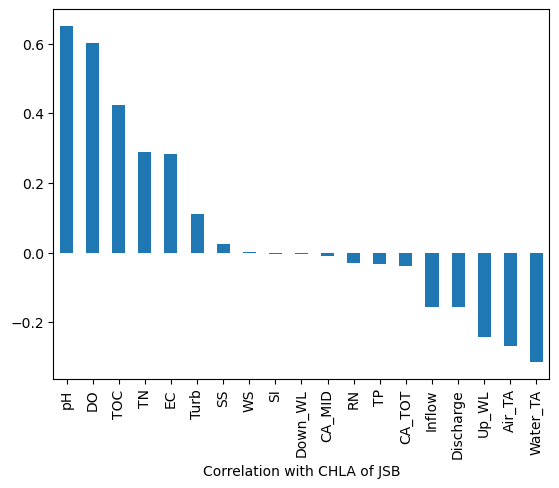

In [104]:
jsb_df.corr()['CHLA'].sort_values(ascending=False)[1:].plot.bar(xlabel="Correlation with CHLA of JSB", rot=90)

**경우: 승촌보**

<Axes: xlabel='Correlation with CHLA of SCB'>

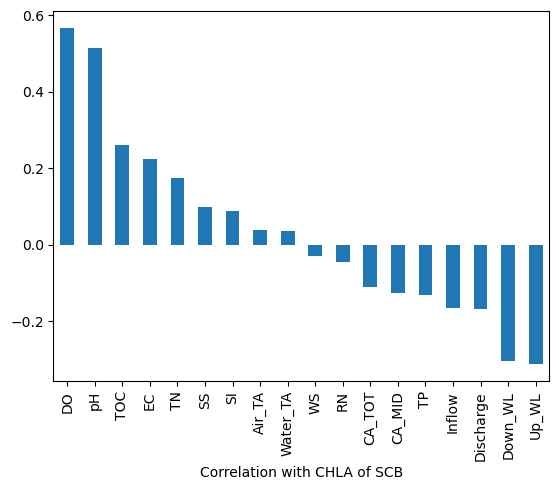

In [105]:
scb_df.corr()['CHLA'].sort_values(ascending=False)[1:].plot.bar(xlabel="Correlation with CHLA of SCB", rot=90)

## 방류량과 수온의 평균값 활용

지정된 특성에 대해 일(day) 단위의 윈도우(window)를 사용하여 지정된 기간동안의 평균값을 새로운 특성으로 추가한다. 특성의 기본값으로 수온과 방류량을 사용한다.

- 일(24시간) 단위로 윈도우 사용
- 일(day) 수를 지정하면 24시간 단위로 변환해서 윈도우 적용.
- 연도(year) 지정 가능

In [106]:
def feature_windowing(df, *, features=['Water_TA', 'Discharge'], window=1, suffix=None, year=None):
    """
    df: 주어진 데이터프레임
    feature: 윈도우 적용대상 특성. 기본값은 수온과 방류량.
    window: 일(day) 단위 윈도우 크기. 기본값은 1일.
    """

    window_ = f"{window*24}h" # 일 단위를 24시간 단위로 변환

    new_features = dict()
    for ft in features:
        if suffix:
            new_features[str(window)+'d_'+ft+suffix] = df[ft].rolling(window=window_, min_periods=1).mean()
        else:
            new_features[str(window)+'d_'+ft] = df[ft].rolling(window=window_, min_periods=1).mean()
    new_features = pd.DataFrame(new_features)

    df_added = pd.concat([df, new_features], axis=1)
    
    if year:
        mask = df_added.index.year == year
        df_added = df_added.loc[mask]
    
    return df_added

예제: 죽산보/승촌보 데이터에 지난 하룻 동안의 수온과 방류량 평균값을 새로운 특성으로 추가

- 죽산보 2022년 데이터에 특성 추가

In [ ]:
feature_windowing(jsb_df, year=2022)

,Water_TA,pH,EC,DO,Turb,TOC,TN,TP,CHLA,Air_TA,RN,WS,SS,SI,CA_TOT,CA_MID,Up_WL,Down_WL,Inflow,Discharge,1d_Water_TA,1d_Discharge
DateTime,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,5.2,7.8,388.0,13.0,5.5,4.6,6.568,0.058,84.2,-4.1,0.0,2.8,0.0,0.0,4.0,0.0,1.49,-1.153333,12.720000,12.720000,5.633333,15.586806
2022-01-01 01:00:00,5.2,7.7,388.0,12.9,5.4,4.5,6.443,0.058,81.7,-4.2,0.0,2.0,0.0,0.0,10.0,4.0,1.49,-1.138333,12.720000,12.720000,5.604167,15.232639
2022-01-01 02:00:00,5.1,7.7,388.0,12.9,5.4,4.5,6.465,0.056,83.6,-4.3,0.0,1.6,0.0,0.0,7.0,7.0,1.49,-1.150000,12.720000,12.720000,5.575000,14.878472
2022-01-01 03:00:00,5.1,7.7,388.0,12.9,5.3,4.5,6.645,0.055,83.5,-4.1,0.0,2.9,0.0,0.0,9.0,0.0,1.49,-1.160000,12.720000,12.720000,5.545833,14.834861
2022-01-01 04:00:00,5.1,7.7,388.0,12.9,5.4,4.5,6.734,0.057,86.2,-4.0,0.0,3.2,0.0,0.0,9.0,0.0,1.49,-1.153333,12.720000,12.720000,5.520833,14.839028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,5.3,8.3,468.0,13.8,7.2,5.1,5.928,0.046,40.6,2.7,0.0,0.0,0.0,0.0,0.0,0.0,1.52,-1.490000,10.288333,10.296667,5.229167,11.368681
2022-12-31 20:00:00,5.2,8.3,468.0,13.6,7.2,4.9,5.969,0.047,38.6,2.5,0.0,0.0,0.0,0.0,0.0,0.0,1.52,-1.486667,10.406667,10.416667,5.225000,11.372778
2022-12-31 21:00:00,5.3,8.3,468.0,13.7,7.1,5.1,5.925,0.046,38.7,1.2,0.0,0.6,0.0,0.0,0.0,0.0,1.52,-1.496667,10.425000,10.426667,5.225000,11.377986


## 모델 훈련

### 전처리: 로그 변환

**로그 변환기**

In [108]:
from sklearn.preprocessing import FunctionTransformer

ft_transformer = FunctionTransformer(np.log1p)

**`CHLA` 특성 로그 변환**

<Axes: ylabel='Count'>

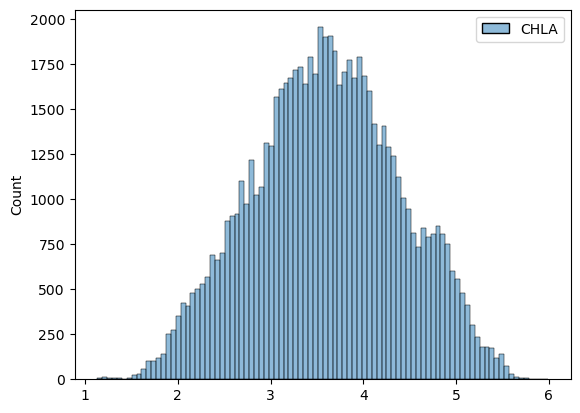

In [109]:
sns.histplot(ft_transformer.fit_transform(jsb_df[['CHLA']]))

**죽산보/승촌보 데이터의 `CHLA` 특성 로그 변환**

In [110]:
jsb_df_log = jsb_df.copy()
jsb_df_log['log_CHLA'] = ft_transformer.fit_transform(jsb_df[['CHLA']])
jsb_df_log.drop(['CHLA'], axis=1, inplace=True)

In [111]:
scb_df_log = scb_df.copy()
scb_df_log['log_CHLA'] = ft_transformer.fit_transform(scb_df[['CHLA']])
scb_df_log.drop(['CHLA'], axis=1, inplace=True)

### 그레이디언트 부스팅 모델

In [112]:
gb_reg = GradientBoostingRegressor(random_state=42)

우선 작동여부를 확인하기 위해 하나의 파라미터 조합만 사용

In [113]:
param_grid = {
    "subsample":[0.6],
    'max_depth':[10], 
    "learning_rate":[0.05],
    'n_estimators':[1200]
    }

**`gridsearch()` 함수**

- 그리드 탐색 훈련을 진행
- 인자: 모델, 하이퍼파라미터 조합, 특성, 윈도우 크기, 년도
    - 년도: `None`이면 전체 데이터셋을 훈련셋으로 지정
- 지정된 특성의 지정된 크기만큼의 윈도우 기간 동안의 평균값을 새로운 특성으로 추가한 후에 훈련 시작

In [114]:
def gridsearch(df, model, parameters, *, 
               features=['Water_TA', 'Discharge'],
               windows=range(1, 7), 
               year=None, 
               best_models_path=None,
               cv=3):

    # best models
    best_model_dict = dict()
    # best models names
    best_model_name_dict = dict()
    # test r2 scores of the best models
    test_score_dict = dict()
    # test rmse scores of the best models
    test_score_rmse_dict = dict()
    # train features of the best models
    input_features_dict = dict()
    # best hyperparameters for each window
    best_params_dict = dict()
    
    for window in windows:
        # window 특성 추가
        df_window = feature_windowing(df, features=features, window=window, year=year)
        # 결측치 제거
        df_window.dropna(inplace=True)

        # 입력 및 타깃 특성 지정
        features_to_be_removed = ['log_CHLA'] + features
        features_ = list(df_window.columns)
        for ft in features_to_be_removed:
            features_.remove(ft)
        
        input_features = features_
        target_feature = 'log_CHLA'

        # 입력 및 타깃 데이터셋 지정
        inputs = df_window.loc[:, input_features]
        targets = df_window[target_feature]

        # 훈련셋과 테스트셋 분리
        X_train, X_test, y_train, y_test = train_test_split(inputs, targets, random_state=42)

        # 그리드 탐색 훈련 시작
        added_feature = window
        print(f"==={added_feature}day(s) temperature and discharge added===")

        model_grid = GridSearchCV(model, param_grid=parameters, cv=cv, verbose=5, 
                                  scoring=['r2', 'neg_mean_squared_error'], refit='r2')
        model_grid.fit(X_train, y_train)

        # 최적 모델 저장
        estimator = model_grid.best_estimator_

        best_model = str(added_feature)+"days"+".pkl"
        joblib.dump(estimator, best_models_path / best_model)

        # 저장된 모델 다시 불러오기
        estimator = joblib.load(best_models_path / best_model)

        best_model_dict[added_feature] = estimator
        best_model_name_dict[added_feature] = best_model
        test_score_dict[added_feature] = estimator.score(X_test, y_test)
        test_score_rmse_dict[added_feature] = np.sqrt(mean_squared_error(y_test, estimator.predict(X_test)))
        input_features_dict[added_feature] = input_features
        best_params_dict[added_feature] = model_grid.best_params_

    dicts = (best_model_dict, 
             best_model_name_dict, 
             test_score_dict, 
             test_score_rmse_dict, 
             input_features_dict, 
             best_params_dict)

    return dicts

**`gridsearch_duet()` 함수**

- 그리드 탐색 훈련을 진행
- 인자: 모델, 하이퍼파라미터 조합, 특성, 윈도우 크기, 년도
- `df1`에 `df2`의 특성에 대해 윈도우를 적용한 결과를 추가해서 훈련셋으로 지정.
    - `df1`: 죽산보 데이터
    - `df2`: 승촌보 데이터

In [115]:
def gridsearch_duet(df1, df2, model, parameters, *, 
                    features1=['Water_TA', 'Discharge'], 
                    features2=['Water_TA', 'Discharge'], 
                    windows=range(1, 7), 
                    year=None, 
                    best_models_path=None,
                    cv=3):
    """
    df1: 죽산보 데이터
    df2: 승촌보 데이터
    """

    # best models
    best_model_dict = dict()
    # best models names
    best_model_name_dict = dict()
    # test r2 scores of the best models
    test_score_dict = dict()
    # test rmse scores of the best models
    test_score_rmse_dict = dict()
    # train features of the best models
    input_features_dict = dict()
    # best hyperparameters for each window
    best_params_dict = dict()
    
    for window in windows:
        # window 특성 추가
        df1_window = feature_windowing(df1, 
                                       features=features1,
                                       window=window,
                                       year=year)
        df2_window = feature_windowing(df2, 
                                       features=features2, 
                                       window=window, 
                                       suffix='_scb', 
                                       year=year)
        
        # 결측치 제거
        df1_window.dropna(inplace=True)
        df2_window.dropna(inplace=True)
        
        # 공통 인덱스 샘플만 활용
        df1_index = df1_window.index
        df2_index = df2_window.index
        common_index = df1_index.intersection(df2_index)
        
        df1_window = df1_window.loc[common_index]
        df2_window = df2_window.loc[common_index]
        
        assert (df1_window.index == df2_window.index).all()
                
        # 입력 및 타깃 특성 지정
        features_to_be_removed = ['log_CHLA'] + features1
        features1_ = list(df1_window.columns)
        for ft in features_to_be_removed:
            features1_.remove(ft)
            
        features2_ = [ft for ft in list(df2_window.columns) if ft.endswith('_scb')]
        
        target_feature = 'log_CHLA'
                
        inputs = pd.concat([df1_window.loc[:, features1_], df2_window.loc[:, features2_]], axis=1)
        targets = df1_window[target_feature]

        # 훈련셋과 테스트셋 분리
        X_train, X_test, y_train, y_test = train_test_split(inputs, targets, random_state=42)

        # 그리드 탐색 훈련 시작
        added_feature = window
        print(f"==={added_feature}day(s) temperature and discharge added===")

        model_grid = GridSearchCV(model, param_grid=parameters, cv=cv, verbose=5, 
                                  scoring=['r2', 'neg_mean_squared_error'], refit='r2')
        model_grid.fit(X_train, y_train)

        # 최적 모델 저장
        estimator = model_grid.best_estimator_

        best_model = str(added_feature)+"days"+".pkl"
        joblib.dump(estimator, best_models_path / best_model)

        # 저장된 모델 다시 불러오기
        estimator = joblib.load(best_models_path / best_model)

        best_model_dict[added_feature] = estimator
        best_model_name_dict[added_feature] = best_model
        test_score_dict[added_feature] = estimator.score(X_test, y_test)
        test_score_rmse_dict[added_feature] = np.sqrt(mean_squared_error(y_test, estimator.predict(X_test)))
        input_features_dict[added_feature] = features1_ + features2_
        best_params_dict[added_feature] = model_grid.best_params_
        
    dicts = (best_model_dict, 
             best_model_name_dict, 
             test_score_dict, 
             test_score_rmse_dict, 
             input_features_dict, 
             best_params_dict)

    return dicts

### 특성 중요도

- 훈련된 최고 성능의 모델 활용
- 특성 중요도를 막대그래프로 그리기

In [116]:
def feature_importance_barplot(best_model_name_dict, 
                               input_features_dict, 
                               best_models_path=None,
                               max_features=None):
    models_trained = best_model_name_dict.keys()
    num_of_models = len(models_trained)

    fig, axs = plt.subplots(num_of_models, sharex=True, figsize=(10, num_of_models*4))

    for idx, model_name in enumerate(models_trained):
        ax = axs[idx]
        # 저장된 모델 다시 불러오기
        best_model = model_name+"days.pkl"
        estimator_ = joblib.load(best_models_path / best_model)
        # 모델이 사용한 특성들 확인
        input_features_ = input_features_dict[model_name]
        # 특성 중요도 확인
        feature_series = pd.Series(data = estimator_.feature_importances_, index = input_features_)
        feature_series = feature_series.sort_values(ascending = False)
        feature_series.index.name = "Features"
        feature_series.name = "Feature Importances"
        
        # 특성 중요도 막대그래프
        if not max_features:
            max_features = len(feature_series)
        # colors = {h:'gray' for h in feature_series.index[:max_features]}
        # colors['DO'] = 'red'

        sns.barplot(ax=ax, 
                    x = feature_series[:max_features], 
                    y = feature_series.index[:max_features], 
                    # palette=colors, 
                    hue=feature_series.index[:max_features])
        # sns.barplot(ax=ax, 
        #             x = feature_series[:max_features], 
        #             y = feature_series.index[:max_features])
        ax.set_title(model_name)

    plt.subplots_adjust(hspace=0.4, wspace=0)
    plt.show()

### 전처리: `DO`와 `pH` 등 기타 특성 삭제

- `DO`와 `pH`는 `CHLA`의 영향을 받는 인자임
- 대기온도, 구름, 풍속 등은 `CHLA`와 특별한 인과관계가 없는 인자임.

In [117]:
to_drop = ['DO', 'pH', 'Air_TA', 'RN', 'WS', 'SS', 'SI', 'CA_TOT', 'CA_MID', 'Down_WL']

In [118]:
df1_jsb = jsb_df_log.drop(to_drop, axis=1)
df2_scb = jsb_df_log.drop(to_drop, axis=1)

### 죽산보 데이터셋에 대해서만 훈련

**학습된 모델 저장**

In [119]:
best_models_path = Path() / "best_models_jsbOnly_and_all_features_wo_original"
best_models_path.mkdir(parents=True, exist_ok=True)

**입력값**

In [120]:
year = None
window_features = df1_jsb.drop(['log_CHLA'], axis=1).columns.to_list()
windows = range(1, 15)

**모델 훈련**

In [121]:
dicts = gridsearch(df1_jsb, gb_reg, param_grid, 
                   features=window_features, 
                   windows=windows, 
                   year=year, 
                   best_models_path=best_models_path,
                   cv=3)

best_model_dict = dicts[0]
best_model_name_dict = dicts[1]
test_score_dict = dicts[2]
test_score_rmse_dict = dicts[3]
input_features_dict = dicts[4]
best_params_dict = dicts[5]

===1day(s) temperature and discharge added===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.017) r2: (test=0.973) total time= 3.9min
[CV 2/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.017) r2: (test=0.973) total time= 3.8min
[CV 3/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.018) r2: (test=0.972) total time= 4.0min
===2day(s) temperature and discharge added===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.015) r2: (test=0.976) total time= 4.1min
[CV 2/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.015) r2: (test=0.976) total time= 4.1min
[CV 3/3] END le

**훈련된 최고 모델의 정보 저장**

- 저장된 모델 불러올 때는 실행 불필요

In [122]:
import json

def save_best(path_to_save, 
              best_model_name_dict, 
              test_score_dict, 
              test_score_rmse_dict, 
              best_params_dict, 
              input_features_dict):

    file_name = 'best_model_name.json'
    with open(path_to_save / file_name, 'w') as json_file:
        json.dump(best_model_name_dict, json_file)

    file_name = 'test_score.json'
    with open(path_to_save / file_name, 'w') as json_file:
        json.dump(test_score_dict, json_file)

    file_name = 'test_score_rmse.json'
    with open(path_to_save / file_name, 'w') as json_file:
        json.dump(test_score_rmse_dict, json_file)

    file_name = 'best_params.json'
    with open(path_to_save / file_name, 'w') as json_file:
        json.dump(best_params_dict, json_file)

    file_name = 'input_features.json'
    with open(path_to_save / file_name, 'w') as json_file:
        json.dump(input_features_dict, json_file)

In [123]:
save_best(best_models_path, 
          best_model_name_dict,
          test_score_dict, 
          test_score_rmse_dict, 
          best_params_dict, 
          input_features_dict)

**최고 성능 모델 정보 불러오기**

In [124]:
import json

def load_best(path_to_save):
    file_name = 'best_model_name.json'
    with open(path_to_save / file_name) as json_file:
        best_model_name_dict = json.load(json_file)

    file_name = 'test_score.json'
    with open(path_to_save / file_name) as json_file:
        test_score_dict = json.load(json_file)

    file_name = 'test_score_rmse.json'
    with open(path_to_save / file_name) as json_file:
        test_score_rmse_dict = json.load(json_file)

    file_name = 'best_params.json'
    with open(path_to_save / file_name) as json_file:
        best_params_dict = json.load(json_file)

    file_name = 'input_features.json'
    with open(path_to_save / file_name) as json_file:
        input_features_dict = json.load(json_file)

    return best_model_name_dict, test_score_dict, test_score_rmse_dict, best_params_dict, input_features_dict

In [125]:
best_model_name_dict = load_best(best_models_path)[0]
test_score_dict = load_best(best_models_path)[1]
test_score_rmse_dict = load_best(best_models_path)[2]
best_params_dict = load_best(best_models_path)[3]
input_features_dict = load_best(best_models_path)[4]

<Figure size 2000x10000 with 0 Axes>

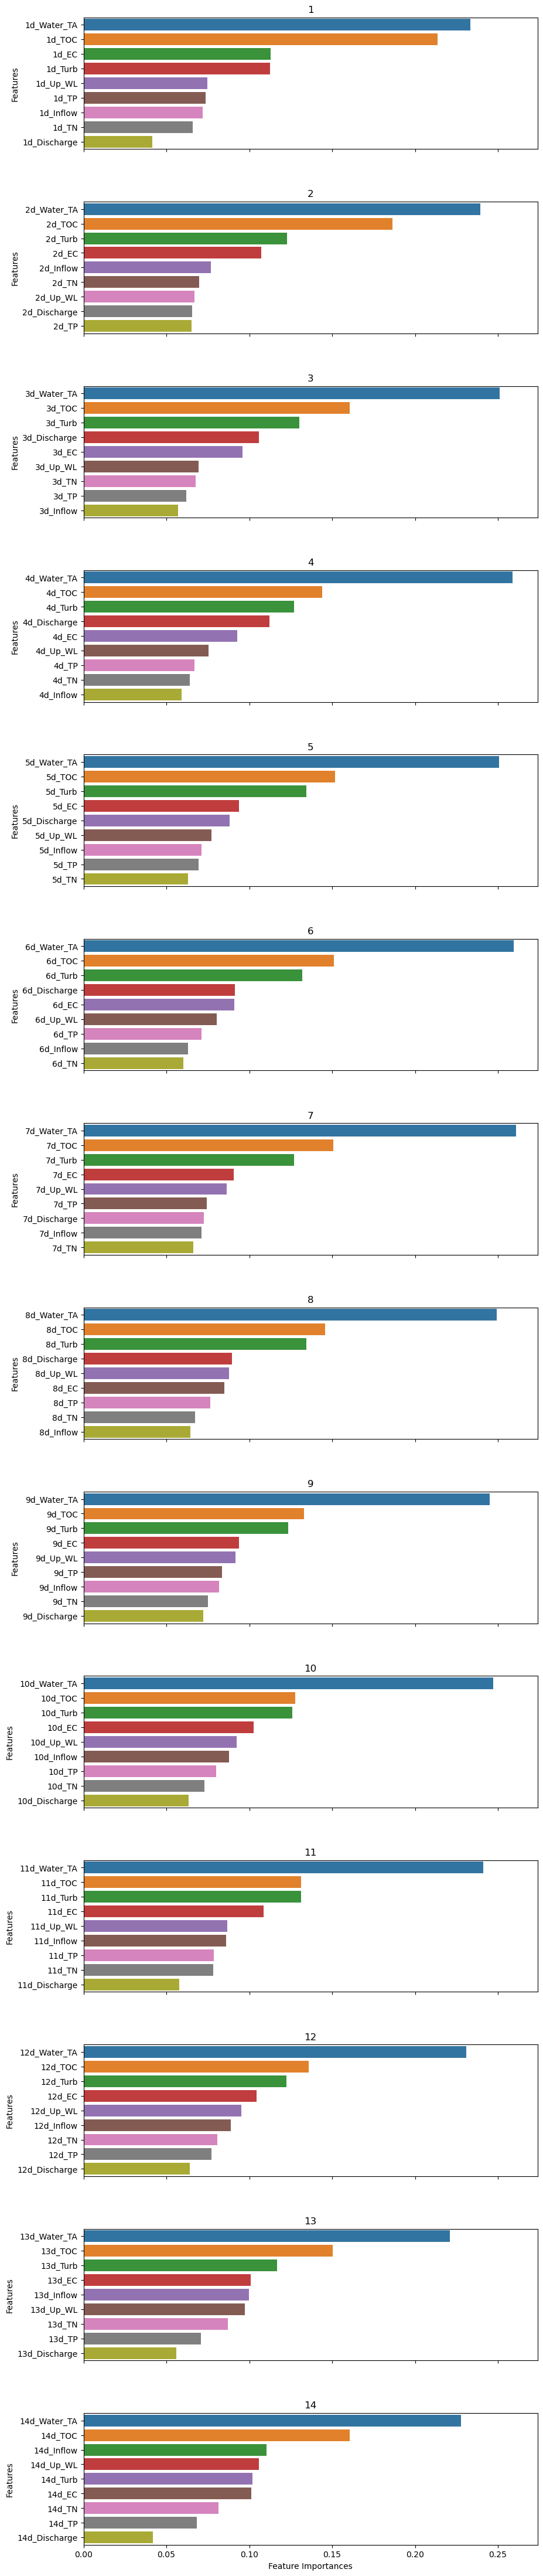

In [126]:
plt.figure(figsize=(20, 100))

feature_importance_barplot(best_model_name_dict, 
                           input_features_dict,
                           best_models_path=best_models_path,
                           max_features=10,
                           )

### 죽산보에 승촌보 일부 특성 추가 후 훈련

**학습된 모델 저장**

In [127]:
best_models_path = Path() / "best_models_with_scb_and_all_features_wo_original"
best_models_path.mkdir(parents=True, exist_ok=True)

**입력값**

In [128]:
year = None
window_features1 = df1_jsb.drop(['log_CHLA'], axis=1).columns.to_list()
window_features2 = df2_scb.columns.to_list()
windows = range(1, 15)

**모델 훈련**

In [129]:
dicts = gridsearch_duet(df1_jsb, df2_scb, gb_reg, param_grid, 
                        features1=window_features1, 
                        features2=window_features2, 
                        windows=windows, 
                        year=year,
                        best_models_path=best_models_path,
                        cv=3)

best_model_dict = dicts[0]
best_model_name_dict = dicts[1]
test_score_dict = dicts[2]
test_score_rmse_dict = dicts[3]
input_features_dict = dicts[4]
best_params_dict = dicts[5]

===1day(s) temperature and discharge added===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.016) r2: (test=0.974) total time= 8.1min
[CV 2/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.017) r2: (test=0.973) total time= 8.1min
[CV 3/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.018) r2: (test=0.972) total time= 8.2min
===2day(s) temperature and discharge added===
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.015) r2: (test=0.976) total time= 8.7min
[CV 2/3] END learning_rate=0.05, max_depth=10, n_estimators=1200, subsample=0.6; neg_mean_squared_error: (test=-0.016) r2: (test=0.975) total time= 8.7min
[CV 3/3] END le

**훈련된 최고 모델의 정보 저장**

In [130]:
save_best(best_models_path, 
          best_model_name_dict,
          test_score_dict, 
          test_score_rmse_dict, 
          best_params_dict, 
          input_features_dict)

**최고 성능 모델 정보 불러오기**

In [131]:
best_model_name_dict = load_best(best_models_path)[0]
test_score_dict = load_best(best_models_path)[1]
test_score_rmse_dict = load_best(best_models_path)[2]
best_params_dict = load_best(best_models_path)[3]
input_features_dict = load_best(best_models_path)[4]

<Figure size 2000x10000 with 0 Axes>

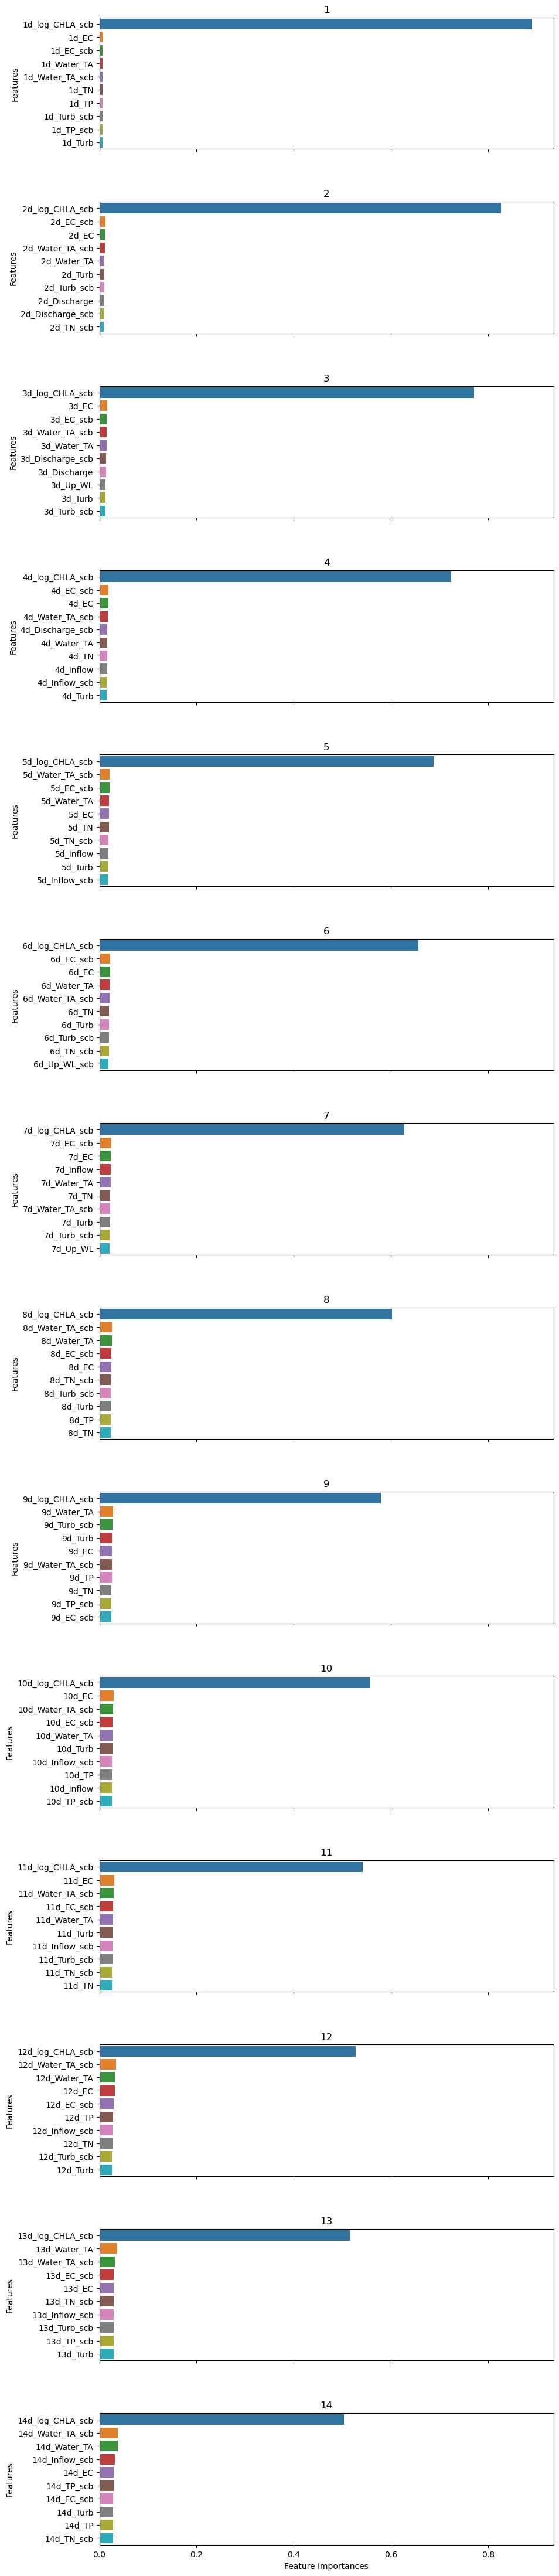

In [132]:
plt.figure(figsize=(20, 100))

feature_importance_barplot(best_model_name_dict, 
                           input_features_dict,
                           best_models_path=best_models_path,
                           max_features=10)